Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list anyone you collaborated with on this workbook

## Lab 10: Classification

**This lab is optional! It was distributed the week of 11/02/2020, and you can complete it whenever you like.**

Welcome to Lab 10, the **last** lab notebook of the semester!


Back in Lab 7, we began exploring methods to answer classification questions. Specifically, we learned how to use  logistic regression to predict the probability that a qualitative outcome occurs. In this notebook, we'll take a look at two other classification methods: k-nearest neighbours and decision tress. Homework 10 will give you more practice using decision trees and ensemble methods.

### Setup

In [2]:
# Run this cell
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

In [3]:
!pip install xlrd
!pip install graphviz

As in Lab 7, we'll work with a modified version of the [ozone level detection dataset](https://archive.ics.uci.edu/ml/datasets/ozone+level+detection) from the UCI Machine Learning Repository, which uses temperature, wind speed, pressure, and other features to decide if a specific day was in fact a normal day or a high ground level ozone day. 

Run the cell below to load ozone.csv into dataframe `df`.

In [4]:
# run this cell
df = pd.read_csv('data/ozone.csv')
df.head()

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Class,intercept
0,4/30/1998,0.0,0.6,0.2,0.3,0.6,1.0,1.3,1.9,1.3,...,17.14,5.87,5745,16.40,43.50,10145,-10,0.0,1.0,1.0
1,5/12/1998,0.8,0.4,0.3,1.4,2.4,2.1,2.7,2.7,4.0,...,20.14,-4.56,5830,8.30,37.80,10095,-15,0.0,0.0,1.0
2,5/18/1998,0.0,0.2,0.0,0.5,0.1,0.4,0.5,0.6,1.3,...,5.38,-2.80,5935,5.70,36.40,10190,-10,0.0,1.0,1.0
3,5/29/1998,1.5,1.3,0.8,0.9,0.9,1.0,1.1,2.5,2.2,...,3.57,-2.00,5890,22.95,49.35,10140,5,0.0,1.0,1.0
4,8/1/1998,0.9,1.1,0.8,1.4,0.8,0.7,2.0,2.9,2.2,...,-4.96,-1.06,5965,23.20,42.40,10180,5,0.0,1.0,1.0


Looking at the columns, we can infer that columns WSR0, WSR1, etc. are the hourly measurements for the wind speed, and the second-to-last column, `Class`, is the variable we want to predict. 0 is a  normal day and 1 is an ozone day. If you want more information on the features, you can read up on the description of the data [here](https://archive.ics.uci.edu/ml/datasets/ozone+level+detection). 

----

### Section 1: k-Nearest Neighbors for Classification

In homework 5, we used the KNN algortithm for regression -- we predicted PM2.5 levels based on the average of the surrounding k measurements. But this time around, we'll use the ozone dataset and KNN to classify whether a day is "normal" or an ozone day. Unlike our logistic regression approach, we'll be working with *two* features, namely, the peak wind speed (`WSR_PK`) and the peak temperature (`T_PK`), instead of just one feature.

Run the following cell to a see a scatter plot of the data.

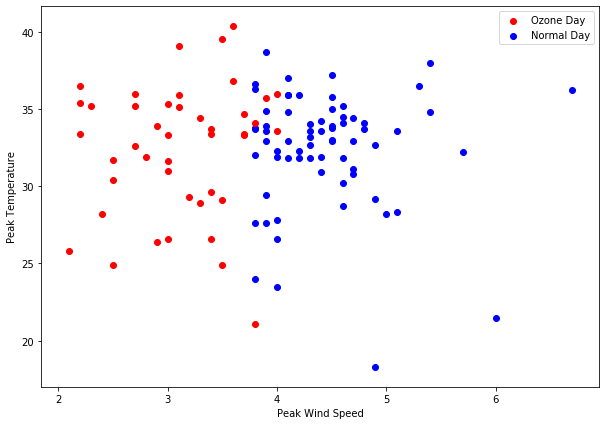

In [5]:
plt.figure(figsize=(10, 7))
plt.ylabel('Peak Temperature')
plt.xlabel('Peak Wind Speed')
for i in range(df.shape[0]):
    if df.Class[i] == 0: # if it's a normal day.
        pltcolor = 'b'
    else:
        pltcolor = 'r'
    plt.scatter(df.WSR_PK[i], df.T_PK[i], c=pltcolor)
plt.legend(['Ozone Day', 'Normal Day']);

Using KNN doesn't seem like a bad idea -- there's only a few cross overs and the possible decision boundary doesn't look too messy. 

Instead of coding the KNN algorithm from scratch like we did in homework 5, we'll make use of scikit-learn's `KNeighborsClassifier`. Check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to see if there are any arguments you could tweak.

**Question 1.1** Split the data into training and tests sets using `train_test_split`, with `test_size = 0.2` and `random_state = 2020`. Then, instantiate a scikit-learn KNN model and fit the model with `WSR_PK` and `T_PK`. First set n_neighbors to 4. Then choose a value for peak wind speed and peak temperature and use `.predict()` to determine the ozone class at those values. Is the class what you expect it to be?

In [6]:
# SOLUTION
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['WSR_PK', 'T_PK']], df.Class, 
                                                    test_size = 0.2, random_state=2020)

knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [7]:
knn.predict([[3, 30]]) #should be an ozone day (1)

array([1.])

**Question 1.2** In a couple sentences, explain in your own words how KNN works for classification problems. You can use formulas if it helps you explain or understand the method. How does KNN decide if a given wind speed and temperature corresponds to an ozone day?

**Answer**: KNN determines the K (K >= 1) points that are closest to the point at which we want to predict a value, and then calculates the expected value of each class within those K points. It will assign the class of the prediction point to be equal to the class with a higher expected value. In our case, for a given point, KNN looks for the K nearest values (using a Euclidean distance, or the square root of the sum of the difference between wind speeds squared and the difference between temperatures squared). It then figure out what fraction of those K points are an ozone day, and what fraction are not an ozone day, and then assigns the class based on the larger fraction.

---

Now that we have our classifier fitted, let's test out some values of K. Before we do so, run the cell below, which defines a function that plots the decision boundary for a classifier when given a number of neighbors.

In [8]:
def plot_boundary(model, X, y, n_neighbors):
    cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA'])
    cmap_bold = ListedColormap(['#0000FF', '#FF0000'])
    h = .02
    
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Peak Wind Speed')
    plt.ylabel('Peak Temperature')
    plt.title("Ozone/Normal Day Classification (k = %i)"
              % (n_neighbors))
    
    plt.show()

**Question 1.3** Plot three decision boundaries, using a small value for K, a large value for K, and one somewhere in between. Use `.fit()` to train the model on the training data, use `plot_boundary()` to produce a plot, and use `.score()` to get the score of the model on the test data - i.e. the mean accuracy, or the proportion of test data points that were accurately classified. Make sure to show the plot and the score for each value of K.

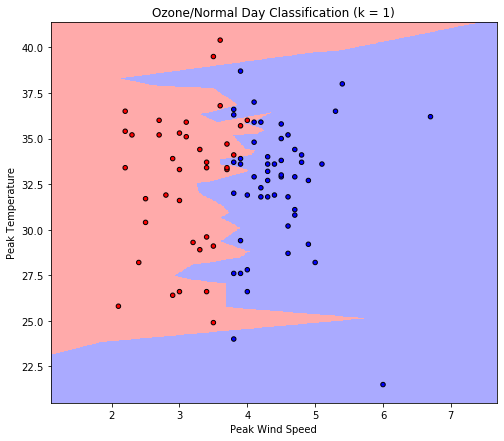

0.9130434782608695


In [9]:
# ex1
knn1 = KNeighborsClassifier(n_neighbors = 1)
knn1.fit(X_train, y_train)
plot_boundary(knn1, X_train, y_train, 1)
print(knn1.score(X_test, y_test))

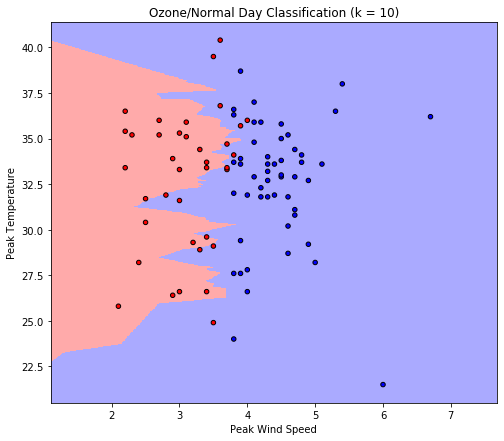

0.782608695652174


In [10]:
# ex2
knn10 = KNeighborsClassifier(n_neighbors = 10)
knn10.fit(X_train, y_train)
plot_boundary(knn10, X_train, y_train, 10)
print(knn10.score(X_test, y_test))

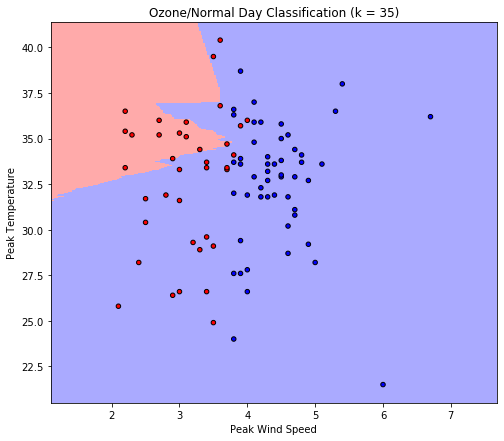

0.782608695652174


In [11]:
# ex3
knn35 = KNeighborsClassifier(n_neighbors = 35)
knn35.fit(X_train, y_train)
plot_boundary(knn35, X_train, y_train, 35)
print(knn35.score(X_test, y_test))

**Question 1.4** Now that we have a a few plots of various decision boundaries, what are some problems with using small or large values for K? Reference your plots in your answer.

**Answer** Small values of K leads to a very flexible model, that possibly picks up patterns that are characteristic of the training dataset only (it leads to high variance). In our case it seems like K = 1 actually performs pretty well, but in other cases it may lead to poor performance on the test data.

Large values of K mean that we're considering a lot of points in our expected value, some of which don't actually have a bearing on our point of interest. We can see that in the plot with K = 35, which underestimates the extent of the variable space that should be classified as an ozone day. A large K leads to an inflexible model, with more bias.

----

### Section 2: Intro to Decision Trees

To prepare you for the homework, let's set up a decision tree to predict ozone days using the same two features we used to train our KNN model in Section 1. We will make use of scikit-learn's `DecisionTreeClassifier`. 

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree

**Question 2.1** Instantiate a `DecisionTreeClassifer` model and call it `O3tree`. Fit the model using the training data, and score it using the training and test data. Assign the scores to the variables `train_score` and `val_score` respectively. 

In [13]:
# Solution
O3tree = DecisionTreeClassifier()
O3tree.fit(X_train, y_train)

print("Number of features: {}".format(O3tree.tree_.n_features))
print("Number of nodes (internal and terminal): {}".format(O3tree.tree_.node_count), "\n")

train_score = O3tree.score(X_train, y_train)
val_score = O3tree.score(X_test, y_test)

print('Train Score: ', train_score)
print('Validation Score: ', val_score)

Number of features: 2
Number of nodes (internal and terminal): 9 

Train Score:  1.0
Validation Score:  0.8695652173913043


What do these outputs represent? We can copy the code and visualize the tree on [Webgraphviz](http://webgraphviz.com). By running the following cell, you'll see a pretty long output -- follow the link and copy and paste the output to get a visualization of the decision tree we fit!

In [14]:
import graphviz
print(tree.export_graphviz(O3tree, feature_names=X_train.columns))

digraph Tree {
node [shape=box] ;
0 [label="WSR_PK <= 3.75\ngini = 0.487\nsamples = 88\nvalue = [51, 37]"] ;
1 [label="gini = 0.0\nsamples = 34\nvalue = [0, 34]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="WSR_PK <= 4.05\ngini = 0.105\nsamples = 54\nvalue = [51, 3]"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
3 [label="T_PK <= 34.0\ngini = 0.291\nsamples = 17\nvalue = [14, 3]"] ;
2 -> 3 ;
4 [label="gini = 0.0\nsamples = 11\nvalue = [11, 0]"] ;
3 -> 4 ;
5 [label="T_PK <= 36.15\ngini = 0.5\nsamples = 6\nvalue = [3, 3]"] ;
3 -> 5 ;
6 [label="gini = 0.0\nsamples = 3\nvalue = [0, 3]"] ;
5 -> 6 ;
7 [label="gini = 0.0\nsamples = 3\nvalue = [3, 0]"] ;
5 -> 7 ;
8 [label="gini = 0.0\nsamples = 37\nvalue = [37, 0]"] ;
2 -> 8 ;
}
